In [19]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
import matplotlib.pyplot as plt
import math
import pprint
import pandas
beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9)
)
print(os.getcwd())
segment = Segment.from_lattice_json("../lattices/diag0bpm.json")


/Users/cgarnier/Desktop/sim/Linac-Simulation-Server/notebooks


In [ ]:
with open('../yaml_configs/tracking_bpm.yaml', "r") as f:
    contents = yaml.safe_load(f)
df = pandas.DataFrame(contents)

    BEND:DIAG0:155:BCTRL  BEND:DIAG0:260:BCTRL  BEND:DIAG0:510:BCTRL  \
1               0.076225              0.092902               0.07464   
2               0.076225              0.092902               0.07464   
3               0.076225              0.092902               0.07464   
4               0.076225              0.092902               0.07464   
5               0.076225              0.092902               0.07464   
6               0.076225              0.092902               0.07464   
7               0.076225              0.092902               0.07464   
8               0.076225              0.092902               0.07464   
9               0.076225              0.092902               0.07464   
10              0.076225              0.092902               0.07464   
11              0.076225              0.092902               0.07464   

    BPMS:DIAG0:190:XSCDTH  BPMS:DIAG0:190:YSCDTH  BPMS:DIAG0:210:XSCDTH  \
1               -1.342316               0.198521            

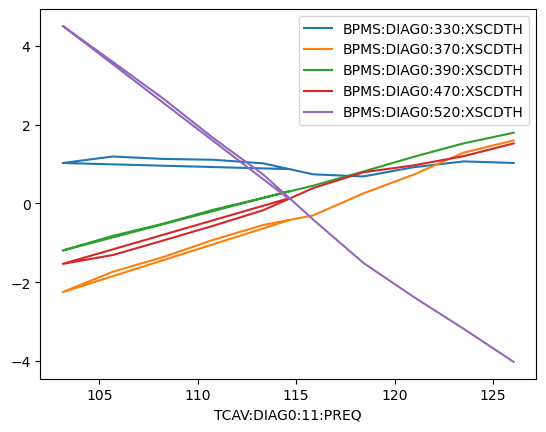

In [42]:

#filter process for tcav_phasing
tcav_phasing = df[df['process'] == 'tcav_phasing']
#filter on bpms and preq
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if 'BPM' in column or 'PREQ' in column]]
#filter out Y
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if 'Y' not in column]]
#filter out upstream of tcav (can filter on bpm and less then 330)
upstream_bpms = ['BPMS:DIAG0:190','BPMS:DIAG0:210', 'BPMS:DIAG0:230', 'BPMS:DIAG0:270', 'BPMS:DIAG0:285']
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if column.rsplit(':',1)[0] not in upstream_bpms ]]
tcav_phasing.plot(x='TCAV:DIAG0:11:PREQ')
phasing_dict = tcav_phasing.to_dict(orient='list')

In [3]:
keys = [key for key in contents.keys()]
bpms = {}
phase = {}
for key in keys:
    if 'BPM' in key:
        bpms[key] = contents[key].copy()
    elif 'TCAV:DIAG0:11:PREQ' in key:
        phase['TCAV:DIAG0:11:PREQ'] = contents[key].copy()

In [4]:
pprint.pprint(bpms.keys())
#pprint.pprint(phase)

dict_keys(['BPMS:DIAG0:190:XSCDTH', 'BPMS:DIAG0:190:YSCDTH', 'BPMS:DIAG0:210:XSCDTH', 'BPMS:DIAG0:210:YSCDTH', 'BPMS:DIAG0:230:XSCDTH', 'BPMS:DIAG0:230:YSCDTH', 'BPMS:DIAG0:270:XSCDTH', 'BPMS:DIAG0:270:YSCDTH', 'BPMS:DIAG0:285:XSCDTH', 'BPMS:DIAG0:285:YSCDTH', 'BPMS:DIAG0:330:XSCDTH', 'BPMS:DIAG0:330:YSCDTH', 'BPMS:DIAG0:370:XSCDTH', 'BPMS:DIAG0:370:YSCDTH', 'BPMS:DIAG0:390:XSCDTH', 'BPMS:DIAG0:390:YSCDTH', 'BPMS:DIAG0:470:XSCDTH', 'BPMS:DIAG0:470:YSCDTH', 'BPMS:DIAG0:520:XSCDTH', 'BPMS:DIAG0:520:YSCDTH'])


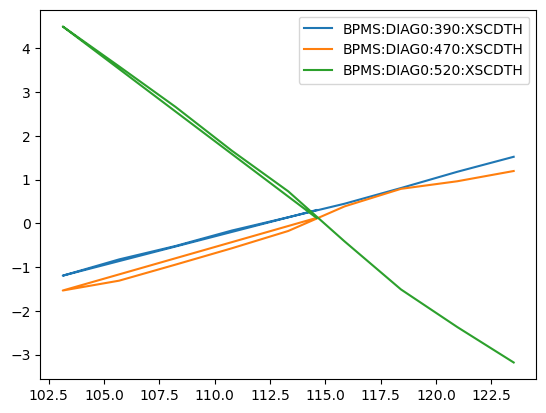

In [ ]:
#TODO: plot signals, recreate graph (done)
#TODO: pass vectorized phases to cheetah. get vectorized bpm positions back. (done)
#TODO: need method that takes control name and finds the corresponding madname in the segment if it exists and returns its index (name to index)
#TODO: need index to array
#TODO: minimize difference in experimental data wityh cheetah using a torch then with xopt

plt.plot(list(phase['TCAV:DIAG0:11:PREQ'].values())[1:11],list(bpms['BPMS:DIAG0:390:XSCDTH'].values())[1:11], label= 'BPMS:DIAG0:390:XSCDTH')
plt.plot(list(phase['TCAV:DIAG0:11:PREQ'].values())[1:11],list(bpms['BPMS:DIAG0:470:XSCDTH'].values())[1:11], label= 'BPMS:DIAG0:470:XSCDTH')
plt.plot(list(phase['TCAV:DIAG0:11:PREQ'].values())[1:11],list(bpms['BPMS:DIAG0:520:XSCDTH'].values())[1:11], label= 'BPMS:DIAG0:520:XSCDTH')
plt.legend() 
plt.show()


# only care about tcav_phasing method

In [6]:
phases = torch.tensor(list(phase['TCAV:DIAG0:11:PREQ'].values())[1:11])
phases = phases/360

In [7]:
print(phases)
#needs to be converted to normalized radian

tensor([0.3183, 0.2865, 0.2936, 0.3006, 0.3077, 0.3148, 0.3219, 0.3289, 0.3360,
        0.3431])


In [8]:
#otr02 = segment.otrdg02.reading
#otr04 = segment.otrdg04.reading
#fig, axs = plt.subplots(2, 7, figsize=(20, 10))
#for i in range(7):
#    axs[0, i].imshow(otr02[i])
#    axs[1, i].imshow(otr04[i])


In [9]:
#data -> ctrl names
#ctrl name to madname
#madname to index
#index to tensor index -> return mu_x for device

bpms2 = list(set([key.rsplit(':',1)[0] for key in bpms.keys()]))
print(bpms2)


with open("../yaml_configs/DIAG0.yaml", "r") as f:
    data = yaml.safe_load(f)
bpm_data = data['bpms'].copy()

def ctrl_to_madname(controls_names:list[str],data: dict):
    madnames = []
    for name in controls_names:
        for key, value in data.items():
            try:
                if value["controls_information"]["control_name"] == name:
                    madnames.append(key.lower())
                    break
            except KeyError:
                continue
        else:
            print('name nout found') # Not found
    return madnames

def names_to_index(names: list[str]):
    ind = []
    elements_to_index = segment.elements
    for index in range(len(elements_to_index)):
        if segment.elements[index].name in names:
            print(f'found {segment.elements[index].name} at index {index}')
            ind.append(index)
    return ind

['BPMS:DIAG0:270', 'BPMS:DIAG0:470', 'BPMS:DIAG0:330', 'BPMS:DIAG0:370', 'BPMS:DIAG0:390', 'BPMS:DIAG0:285', 'BPMS:DIAG0:190', 'BPMS:DIAG0:230', 'BPMS:DIAG0:210', 'BPMS:DIAG0:520']


In [10]:
madnames = ctrl_to_madname(bpms2, bpm_data)

In [11]:
ind = names_to_index(madnames)

found bpmdg001 at index 147
found bpmdg002 at index 152
found bpmdg003 at index 157
found bpmdg004 at index 166
found bpmdg005 at index 172
found bpmdg0rf at index 181
found bpmdg008 at index 188
found bpmdg009 at index 194
found bpmdg011 at index 214
found bpmdg012 at index 220


In [17]:
segment.tcxdg0.voltage = torch.tensor(.135e6)
for phase in phases:
    segment.tcxdg0.phase = phase
    tracked_beam = segment.track(beam)
    position_data = segment.get_beam_attrs_along_segment(
        ("mu_x"),
        incoming=beam,
    )
    #print(type(position_data))
    mu_x = position_data[ind]
    print(mu_x)

    # need to convert to meters? idk
    # position of the bpms is in mm

tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.2620e-03,  1.7580e-03,  8.4505e-04, -9.7898e-03])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.4241e-03,  1.8836e-03,  9.0492e-04, -1.0486e-02])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.3963e-03,  1.8621e-03,  8.9467e-04, -1.0367e-02])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.3638e-03,  1.8369e-03,  8.8265e-04, -1.0227e-02])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.3265e-03,  1.8080e-03,  8.6889e-04, -1.0067e-02])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.2846e-03,  1.7756e-03,  8.5342e-04, -9.8872e-03])
tensor([-1.6953e-05, -1.0400e-06,  1.0056e-05,  1.6079e-06, -2.2382e-06,
        -1.1316e-05,  2.2382e-03,  1.7396e-03

In [13]:
# need to see bpm data... then stack and minimize difference while iterating


In [18]:
bpms['BPMS:DIAG0:190:XSCDTH'].values()

dict_values([-1.4373374938964842, -1.342315673828125, -1.2412887573242186, -1.1286048889160156, -1.2144424438476562, -1.1844169616699218, -1.2949813842773437, -1.4966819763183592, -1.5281204223632812, -1.3582115173339844, -1.2342239379882811, -1.2638961791992187, -1.4172027587890623, -1.4217948913574219, -1.508692169189453, -1.5383644104003906, -1.4571189880371094, -1.4680694580078124, -1.3426689147949218, -1.4076652526855469, -1.42991943359375, -1.2843841552734374, -1.4225013732910154, -1.4323921203613281, -1.4874977111816405, -1.3490272521972655, -1.228925323486328, -1.4111976623535156, -1.4048393249511717, -1.4341583251953125, -1.483258819580078, -1.5365982055664062, -1.6164306640625, -1.5065727233886719, -1.325006866455078, -1.4228546142578125, -1.4330986022949217, -1.4525268554687498, -1.4874977111816405, -1.3564453125, -1.2843841552734374, -1.5182296752929687, -1.4458152770996093, -1.3712814331054686, -1.4313323974609373, -1.3885902404785155, -1.325006866455078, -1.22256698608398

In [15]:
print(ind)

[147, 152, 157, 166, 172, 181, 188, 194, 214, 220]


In [ ]:
# do not need the first 6 bpms, bpm0-5
